In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import geopandas as gpd
from p_tqdm import p_map
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
from matplotlib import gridspec
import matplotlib as mpl

In [2]:
#%matplotlib widget

# Load data

In [3]:
# load cci lakes
cci_lake_list = pd.read_csv("../data/cci_lakes_hydrolake_depth.csv")["CCI ID"].to_numpy()
lakes_with_clz = pd.read_csv("../data/lakes_with_climate_zone.csv", index_col = 0).loc[cci_lake_list]
cci_lakes = pd.read_csv("../data/ESA_CCI_static_lake_mask_v2_1km_UoR_metadata_fv2.1_06Oct2021_4laketemp.csv", index_col=0).loc[cci_lake_list]
cci_lakes = pd.concat([cci_lakes, lakes_with_clz.loc[:,["climate_zone"]]], axis = 1)
cci_lakes_gdf = gpd.GeoDataFrame(cci_lakes, geometry=gpd.points_from_xy(cci_lakes['LON CENTRE'], cci_lakes['LAT CENTRE']),
                                crs="epsg:4326")
cci_lakes_gdf.index.name = "cci_lake_id"

In [4]:
# directory saved simulated temperature
obs_full_path = "/nas/cee-hydro/laketemp_bias/era5land/water_temp.csv"
obs_cloud_path = "/nas/cee-hydro/laketemp_bias/era5land/water_temp_cloud.csv"
a2w_full_dir = "/nas/cee-hydro/laketemp_bias/simulations/a2w_full_sim"
a2w_cloud_dir = "/nas/cee-hydro/laketemp_bias/simulations/a2w_cloud_sim"
lstm_full_dir = "/nas/cee-hydro/laketemp_bias/simulations/lstm_full_sim"
lstm_cloud_dir = "/nas/cee-hydro/laketemp_bias/simulations/lstm_cloud_sim"

In [5]:
train_stats = pd.read_csv("../data/sim_stats_trainperiod_ensemble_mean.csv", index_col = 0)
val_stats = pd.read_csv("../data/sim_stats_valperiod_ensemble_mean.csv", index_col = 0)
total_stats = pd.read_csv("../data/sim_stats_totalperiod_ensemble_mean.csv", index_col = 0)
train_stats_obs = pd.read_csv("../data/obs_stats_train.csv", index_col = 0)
val_stats_obs = pd.read_csv("../data/obs_stats_val.csv", index_col = 0)
total_stats_obs = pd.read_csv("../data/obs_stats_total.csv", index_col = 0)

In [6]:
# we need to filter lakes with only ice-covered lakes
# load observation
df_tw = pd.read_csv("/nas/cee-hydro/laketemp_bias/era5land/water_temp.csv", index_col = 0, parse_dates=True)
df_tw_icedays = (df_tw <= 0).sum(axis = 0)
ice_lake_ids = df_tw_icedays.loc[df_tw_icedays > 0].index.astype(int).to_numpy()

# Explore the stats and find lakes I want to plto

In [7]:
# # view tmean difference
# stats_gdf_total.explore(column = "a2w_diff_mean",         
#                         vmin=-0.2,
#                         vmax=0.2,
#                         cmap = "coolwarm")

# Case 1, High temperature in high latitude area
LSTM is having trouble reaching the top temperature and cannot stably maintained at 0

In [11]:
lake_name

' Kamchatka river, Russian Federation'

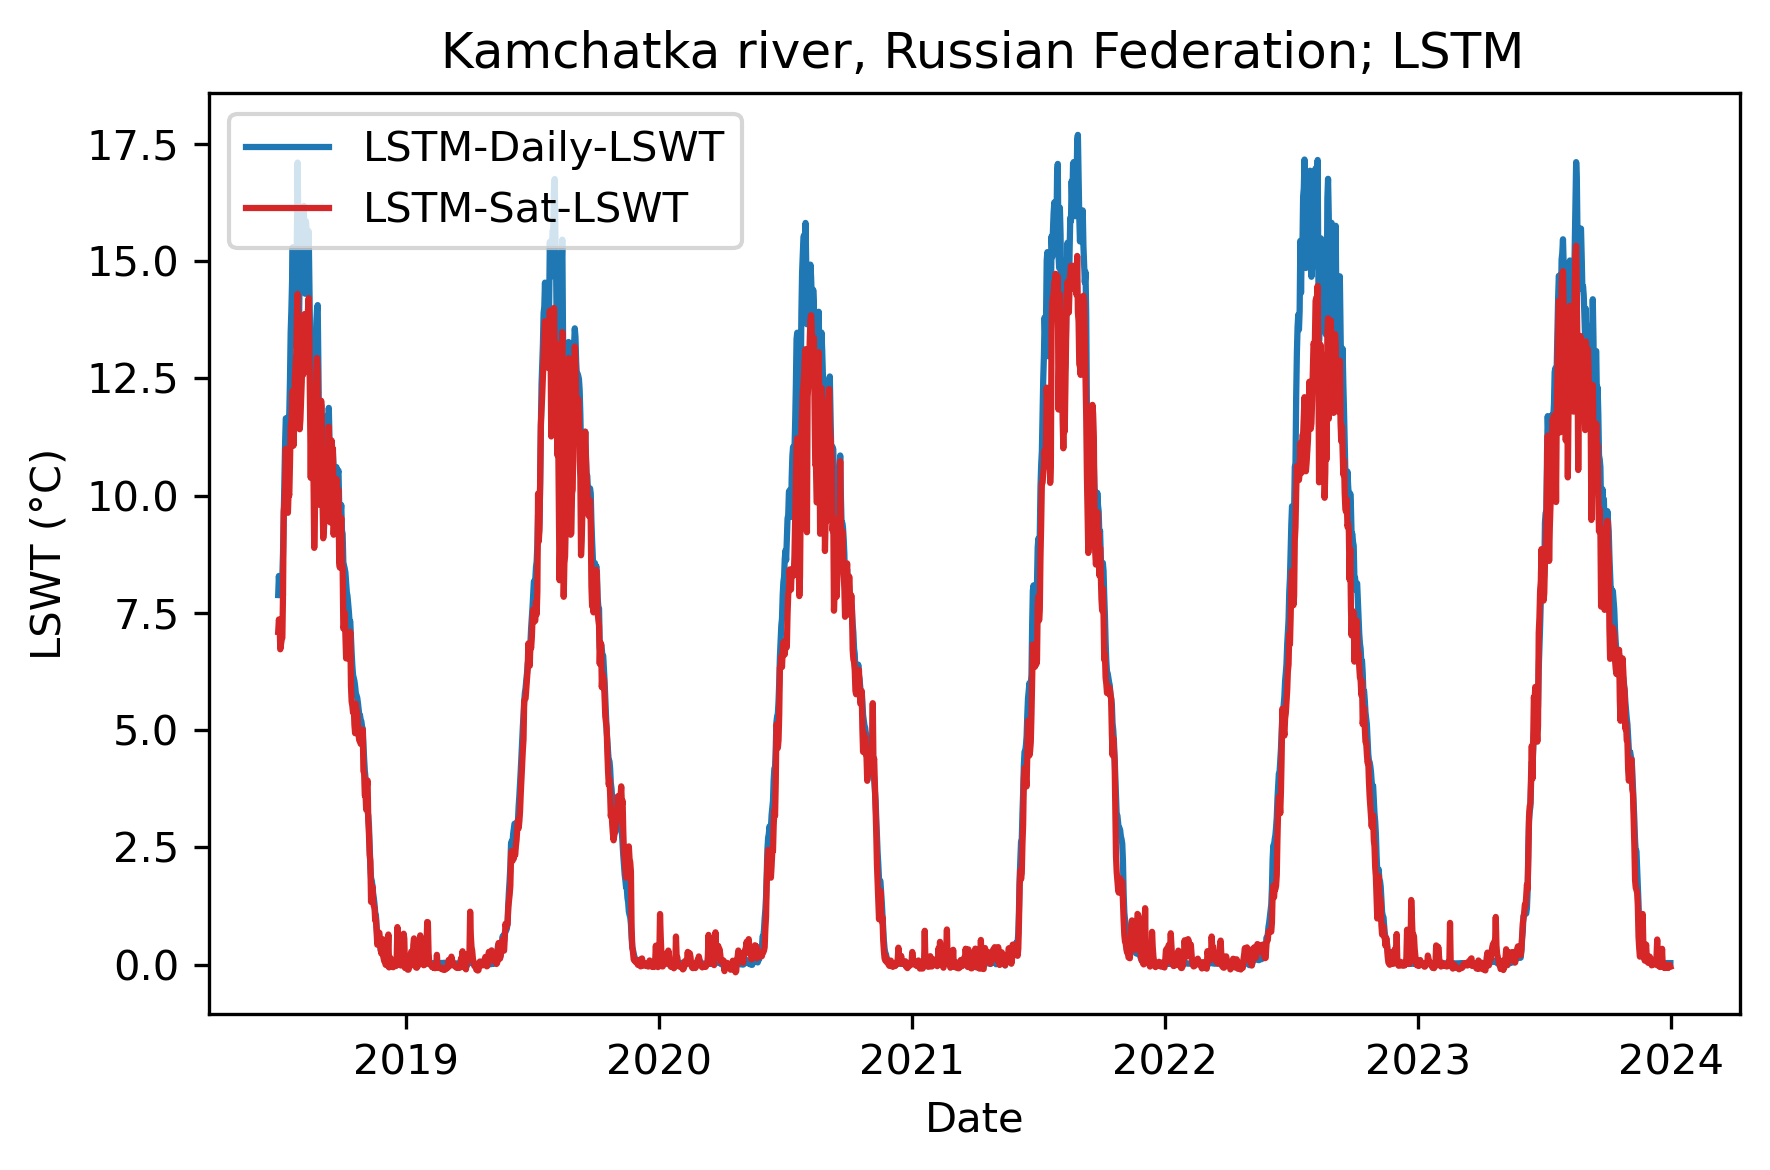

In [9]:
test_lake_id = "338"
lake_name = cci_lakes_gdf.loc[int(test_lake_id), "NAME"] + ", " + cci_lakes_gdf.loc[int(test_lake_id), "COUNTRY"]
a2w_full_sim = pd.read_csv(f"{a2w_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
a2w_cloud_sim = pd.read_csv(f"{a2w_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_full_sim = pd.read_csv(f"{lstm_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_cloud_sim = pd.read_csv(f"{lstm_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
obs_full = pd.read_csv(obs_full_path, index_col=0, parse_dates=True).loc[:, test_lake_id]
obs_cloud = pd.read_csv(obs_cloud_path, index_col=0, parse_dates=True).loc[:, test_lake_id]

fig, ax = plt.subplots(figsize=(6, 4), sharex=True, sharey=True, dpi=300)
date_range = pd.date_range("2018-07-01", "2023-12-31")
fig_labels = ["(a)", "(b)", "(c)"]

# Time series of observations
sns.lineplot(lstm_full_sim.mean(axis=1).loc[date_range], label="LSTM-Daily-LSWT", ax=ax, color="tab:blue")
sns.lineplot(lstm_cloud_sim.mean(axis=1).loc[date_range], label="LSTM-Sat-LSWT", ax=ax, color="tab:red")
ax.set_title(f"{lake_name}; LSTM")
ax.set_xlabel("Date")
ax.set_ylabel("LSWT (°C)")
ax.legend()
# ax.tick_params(axis='x', )

plt.tight_layout()

In [ ]:
test_lake_id = "338"
lake_name = cci_lakes_gdf.loc[int(test_lake_id), "NAME"] + ", " + cci_lakes_gdf.loc[int(test_lake_id), "COUNTRY"]
a2w_full_sim = pd.read_csv(f"{a2w_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
a2w_cloud_sim = pd.read_csv(f"{a2w_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_full_sim = pd.read_csv(f"{lstm_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_cloud_sim = pd.read_csv(f"{lstm_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
obs_full = pd.read_csv(obs_full_path, index_col=0, parse_dates=True).loc[:, test_lake_id]
obs_cloud = pd.read_csv(obs_cloud_path, index_col=0, parse_dates=True).loc[:, test_lake_id]

fig, ax = plt.subplots(figsize=(6, 4), sharex=True, sharey=True, dpi=300)
date_range = pd.date_range("2018-07-01", "2023-12-31")
fig_labels = ["(a)", "(b)", "(c)"]

# Time series of observations
sns.lineplot(a2w_full_sim.mean(axis=1).loc[date_range], label="A2w-Daily-LSWT", ax=ax, color="tab:blue")
sns.lineplot(a2w_cloud_sim.mean(axis=1).loc[date_range], label="A2w-Sat-LSWT", ax=ax, color="tab:red")
ax.set_title(f"{lake_name}; Air2water")
ax.set_xlabel("Date")
ax.set_ylabel("LSWT (°C)")
ax.legend()
# ax.tick_params(axis='x', )

plt.tight_layout()

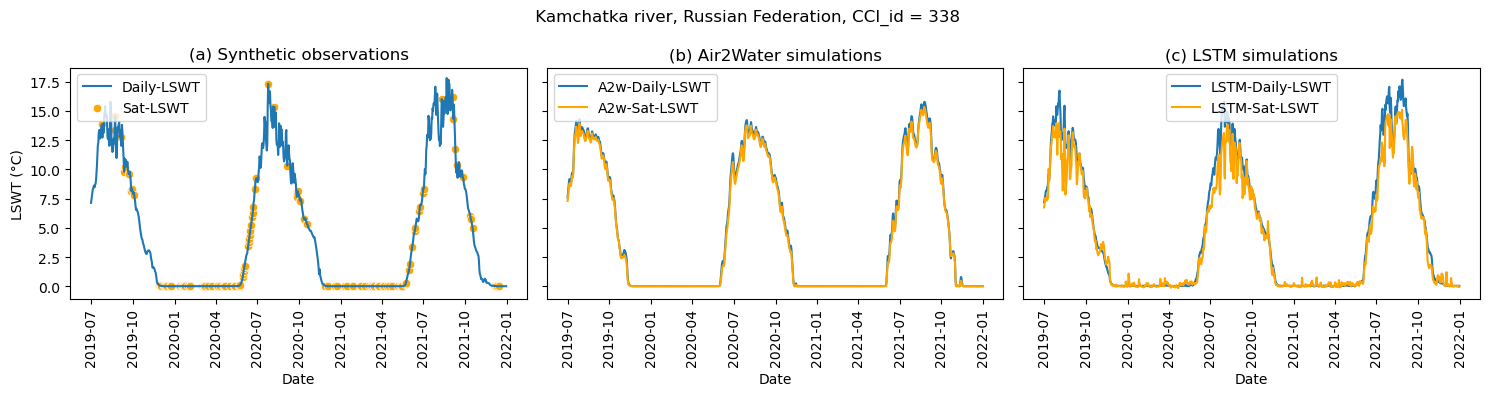

In [37]:
test_lake_id = "338"
lake_name = cci_lakes_gdf.loc[int(test_lake_id), "NAME"] + ", " + cci_lakes_gdf.loc[int(test_lake_id), "COUNTRY"]
a2w_full_sim = pd.read_csv(f"{a2w_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
a2w_cloud_sim = pd.read_csv(f"{a2w_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_full_sim = pd.read_csv(f"{lstm_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_cloud_sim = pd.read_csv(f"{lstm_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
obs_full = pd.read_csv(obs_full_path, index_col=0, parse_dates=True).loc[:, test_lake_id]
obs_cloud = pd.read_csv(obs_cloud_path, index_col=0, parse_dates=True).loc[:, test_lake_id]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
date_range = pd.date_range("2019-07-01", "2021-12-31")
fig_labels = ["(a)", "(b)", "(c)"]

# Time series of observations
sns.lineplot(obs_full.loc[date_range], label="Daily-LSWT", ax=axes[0], color="tab:blue")
sns.scatterplot(obs_cloud.loc[date_range], label="Sat-LSWT", ax=axes[0], color="orange")
axes[0].set_title(f"{fig_labels[0]} Synthetic observations")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("LSWT (°C)")
axes[0].legend()
axes[0].tick_params(axis='x', labelrotation=90, )
# Time series of Air2Water simulations
sns.lineplot(a2w_full_sim.mean(axis=1).loc[date_range], label="A2w-Daily-LSWT", ax=axes[1], color="tab:blue")
sns.lineplot(a2w_cloud_sim.mean(axis=1).loc[date_range], label="A2w-Sat-LSWT", ax=axes[1], color="orange")
axes[1].set_title(f"{fig_labels[1]} Air2Water simulations")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].tick_params(axis='x', labelrotation=90, )
# Time series of LSTM simulations
sns.lineplot(lstm_full_sim.mean(axis=1).loc[date_range], label="LSTM-Daily-LSWT", ax=axes[2], color="tab:blue")
sns.lineplot(lstm_cloud_sim.mean(axis=1).loc[date_range], label="LSTM-Sat-LSWT", ax=axes[2], color="orange")
axes[2].set_title(f"{fig_labels[2]} LSTM simulations")
axes[2].set_xlabel("Date")
axes[2].legend()
axes[2].tick_params(axis='x', labelrotation=90, )
fig.suptitle(f"{lake_name}, CCI_id = {test_lake_id}")
plt.tight_layout()

In [14]:
fig.savefig("../figs/case1_lstm_extreme.png", dpi = 300, bbox_inches='tight')

# Case 2, Twarm bias in tropical

Air2water is not able to manage the bias in tropical area

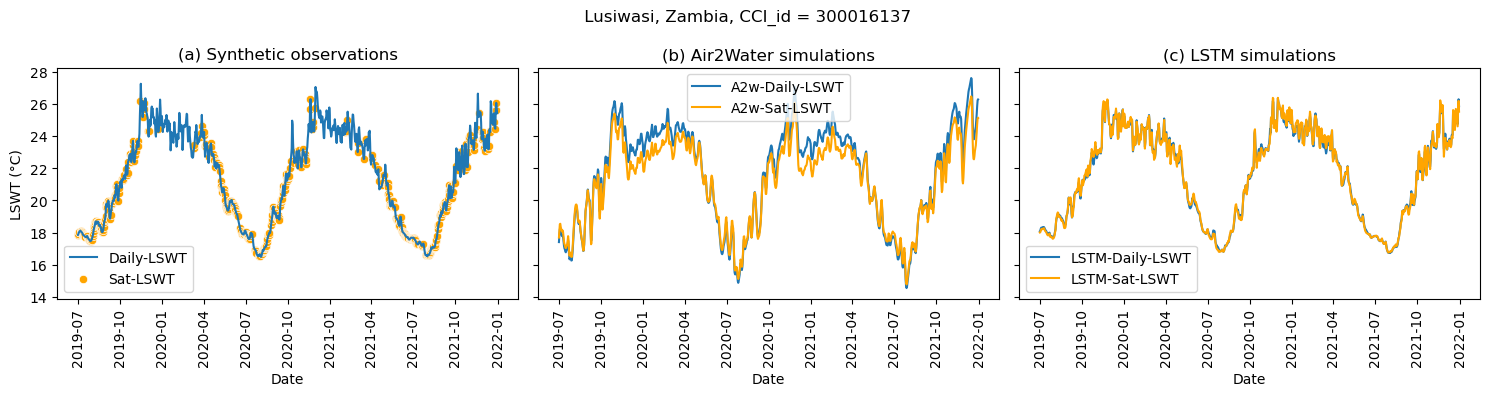

In [15]:
test_lake_id = "300016137"
lake_name = cci_lakes_gdf.loc[int(test_lake_id), "NAME"] + ", " + cci_lakes_gdf.loc[int(test_lake_id), "COUNTRY"]
a2w_full_sim = pd.read_csv(f"{a2w_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
a2w_cloud_sim = pd.read_csv(f"{a2w_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_full_sim = pd.read_csv(f"{lstm_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_cloud_sim = pd.read_csv(f"{lstm_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
obs_full = pd.read_csv(obs_full_path, index_col=0, parse_dates=True).loc[:, test_lake_id]
obs_cloud = pd.read_csv(obs_cloud_path, index_col=0, parse_dates=True).loc[:, test_lake_id]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
date_range = pd.date_range("2019-07-01", "2021-12-31")
fig_labels = ["(a)", "(b)", "(c)"]

# Time series of observations
sns.lineplot(obs_full.loc[date_range], label="Daily-LSWT", ax=axes[0], color="tab:blue")
sns.scatterplot(obs_cloud.loc[date_range], label="Sat-LSWT", ax=axes[0], color="orange")
axes[0].set_title(f"{fig_labels[0]} Synthetic observations")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("LSWT (°C)")
axes[0].legend()
axes[0].tick_params(axis='x', labelrotation=90, )
# Time series of Air2Water simulations
sns.lineplot(a2w_full_sim.mean(axis=1).loc[date_range], label="A2w-Daily-LSWT", ax=axes[1], color="tab:blue")
sns.lineplot(a2w_cloud_sim.mean(axis=1).loc[date_range], label="A2w-Sat-LSWT", ax=axes[1], color="orange")
axes[1].set_title(f"{fig_labels[1]} Air2Water simulations")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].tick_params(axis='x', labelrotation=90, )
# Time series of LSTM simulations
sns.lineplot(lstm_full_sim.mean(axis=1).loc[date_range], label="LSTM-Daily-LSWT", ax=axes[2], color="tab:blue")
sns.lineplot(lstm_cloud_sim.mean(axis=1).loc[date_range], label="LSTM-Sat-LSWT", ax=axes[2], color="orange")
axes[2].set_title(f"{fig_labels[2]} LSTM simulations")
axes[2].set_xlabel("Date")
axes[2].legend()
axes[2].tick_params(axis='x', labelrotation=90, )
fig.suptitle(f"{lake_name}, CCI_id = {test_lake_id}")
plt.tight_layout()

In [16]:
fig.savefig("../figs/case2_a2w_tropical.png", dpi = 300, bbox_inches='tight')

# Case 3, Ice duration

When cloud occur in winter, air2water chose to predict colder while LSTM is not confident to reach the boundary.

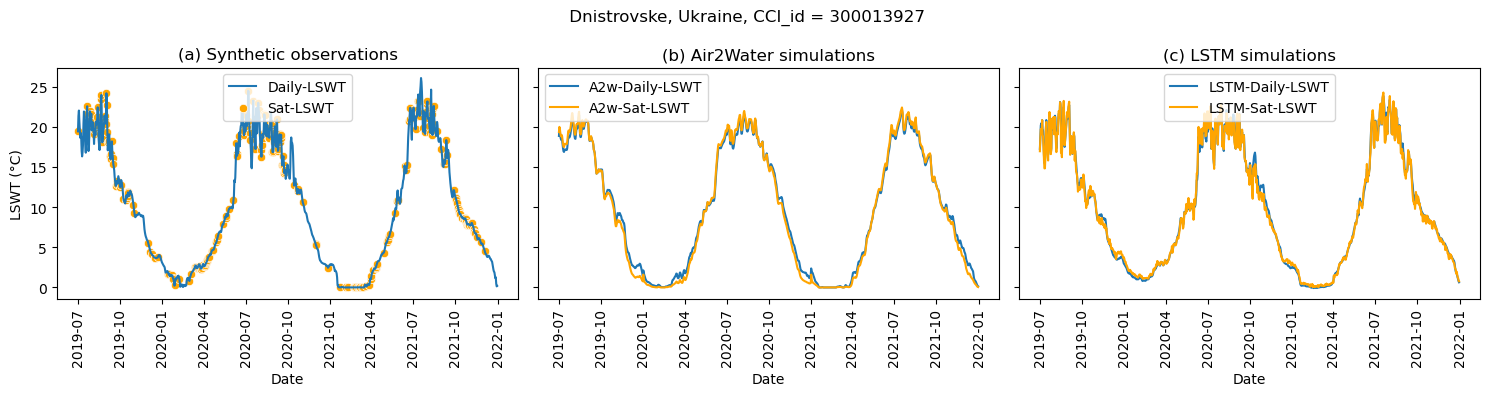

In [29]:
test_lake_id = "300013927"
lake_name = cci_lakes_gdf.loc[int(test_lake_id), "NAME"] + ", " + cci_lakes_gdf.loc[int(test_lake_id), "COUNTRY"]
a2w_full_sim = pd.read_csv(f"{a2w_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
a2w_cloud_sim = pd.read_csv(f"{a2w_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_full_sim = pd.read_csv(f"{lstm_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_cloud_sim = pd.read_csv(f"{lstm_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
obs_full = pd.read_csv(obs_full_path, index_col=0, parse_dates=True).loc[:, test_lake_id]
obs_cloud = pd.read_csv(obs_cloud_path, index_col=0, parse_dates=True).loc[:, test_lake_id]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
date_range = pd.date_range("2019-07-01", "2021-12-31")
fig_labels = ["(a)", "(b)", "(c)"]

# Time series of observations
sns.lineplot(obs_full.loc[date_range], label="Daily-LSWT", ax=axes[0], color="tab:blue")
sns.scatterplot(obs_cloud.loc[date_range], label="Sat-LSWT", ax=axes[0], color="orange")
axes[0].set_title(f"{fig_labels[0]} Synthetic observations")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("LSWT (°C)")
axes[0].legend()
axes[0].tick_params(axis='x', labelrotation=90, )
# Time series of Air2Water simulations
sns.lineplot(a2w_full_sim.mean(axis=1).loc[date_range], label="A2w-Daily-LSWT", ax=axes[1], color="tab:blue")
sns.lineplot(a2w_cloud_sim.mean(axis=1).loc[date_range], label="A2w-Sat-LSWT", ax=axes[1], color="orange")
axes[1].set_title(f"{fig_labels[1]} Air2Water simulations")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].tick_params(axis='x', labelrotation=90, )
# Time series of LSTM simulations
sns.lineplot(lstm_full_sim.mean(axis=1).loc[date_range], label="LSTM-Daily-LSWT", ax=axes[2], color="tab:blue")
sns.lineplot(lstm_cloud_sim.mean(axis=1).loc[date_range], label="LSTM-Sat-LSWT", ax=axes[2], color="orange")
axes[2].set_title(f"{fig_labels[2]} LSTM simulations")
axes[2].set_xlabel("Date")
axes[2].legend()
axes[2].tick_params(axis='x', labelrotation=90, )
fig.suptitle(f"{lake_name}, CCI_id = {test_lake_id}")
plt.tight_layout()

In [30]:
fig.savefig("../figs/case3_a2w_iceduration.png", dpi = 300, bbox_inches='tight')

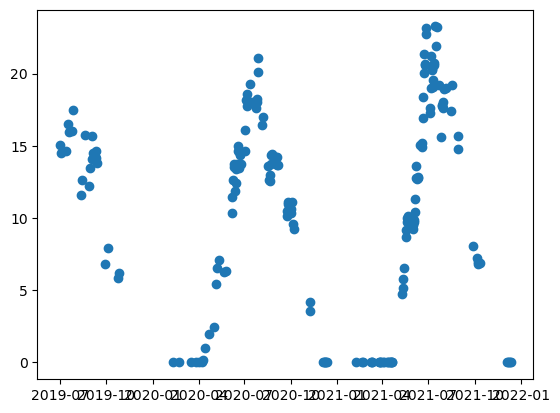

In [13]:
plt.scatter(date_range, obs_cloud.loc[date_range])

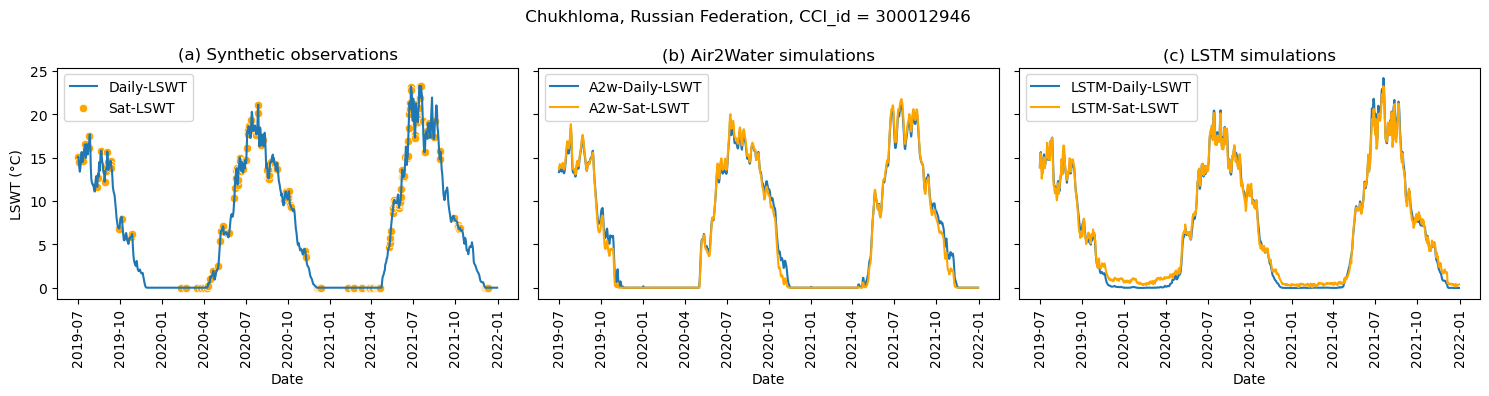

In [11]:
test_lake_id = "300012946"
lake_name = cci_lakes_gdf.loc[int(test_lake_id), "NAME"] + ", " + cci_lakes_gdf.loc[int(test_lake_id), "COUNTRY"]
a2w_full_sim = pd.read_csv(f"{a2w_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
a2w_cloud_sim = pd.read_csv(f"{a2w_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_full_sim = pd.read_csv(f"{lstm_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_cloud_sim = pd.read_csv(f"{lstm_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
obs_full = pd.read_csv(obs_full_path, index_col=0, parse_dates=True).loc[:, test_lake_id]
obs_cloud = pd.read_csv(obs_cloud_path, index_col=0, parse_dates=True).loc[:, test_lake_id]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
date_range = pd.date_range("2019-07-01", "2021-12-31")
fig_labels = ["(a)", "(b)", "(c)"]

# Time series of observations
sns.lineplot(obs_full.loc[date_range], label="Daily-LSWT", ax=axes[0], color="tab:blue")
sns.scatterplot(obs_cloud.loc[date_range], label="Sat-LSWT", ax=axes[0], color="orange")
axes[0].set_title(f"{fig_labels[0]} Synthetic observations")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("LSWT (°C)")
axes[0].legend()
axes[0].tick_params(axis='x', labelrotation=90, )
# Time series of Air2Water simulations
sns.lineplot(a2w_full_sim.mean(axis=1).loc[date_range], label="A2w-Daily-LSWT", ax=axes[1], color="tab:blue")
sns.lineplot(a2w_cloud_sim.mean(axis=1).loc[date_range], label="A2w-Sat-LSWT", ax=axes[1], color="orange")
axes[1].set_title(f"{fig_labels[1]} Air2Water simulations")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].tick_params(axis='x', labelrotation=90, )
# Time series of LSTM simulations
sns.lineplot(lstm_full_sim.mean(axis=1).loc[date_range], label="LSTM-Daily-LSWT", ax=axes[2], color="tab:blue")
sns.lineplot(lstm_cloud_sim.mean(axis=1).loc[date_range], label="LSTM-Sat-LSWT", ax=axes[2], color="orange")
axes[2].set_title(f"{fig_labels[2]} LSTM simulations")
axes[2].set_xlabel("Date")
axes[2].legend()
axes[2].tick_params(axis='x', labelrotation=90, )
fig.suptitle(f"{lake_name}, CCI_id = {test_lake_id}")
plt.tight_layout()

In [35]:
fig.savefig("../figs/case3_lstm_iceduration.png", dpi = 300, bbox_inches='tight')

# Case 4, lake dried out

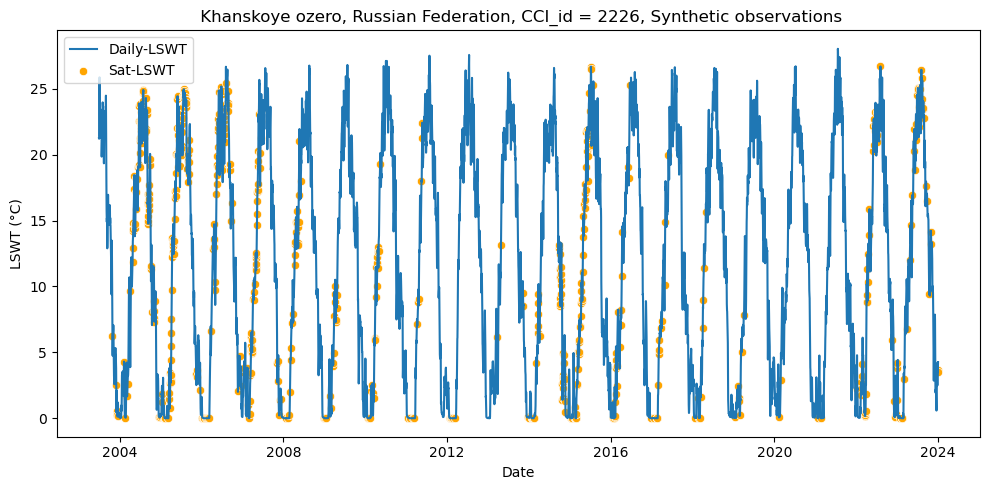

In [19]:
test_lake_id = "2226"
lake_name = cci_lakes_gdf.loc[int(test_lake_id), "NAME"] + ", " + cci_lakes_gdf.loc[int(test_lake_id), "COUNTRY"]
# lake_name = "Changdang lake, China"
a2w_full_sim = pd.read_csv(f"{a2w_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
a2w_cloud_sim = pd.read_csv(f"{a2w_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_full_sim = pd.read_csv(f"{lstm_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_cloud_sim = pd.read_csv(f"{lstm_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
obs_full = pd.read_csv(obs_full_path, index_col=0, parse_dates=True).loc[:, test_lake_id]
obs_cloud = pd.read_csv(obs_cloud_path, index_col=0, parse_dates=True).loc[:, test_lake_id]

fig, axes = plt.subplots(1, 1, figsize=(10, 5))
date_range = pd.date_range("2003-07-01", "2023-12-31")

# Time series of observations
sns.lineplot(obs_full.loc[date_range], label="Daily-LSWT", ax=axes, color="tab:blue")
sns.scatterplot(obs_cloud.loc[date_range], label="Sat-LSWT", ax=axes, color="orange")
axes.set_title(f"{lake_name}, CCI_id = {test_lake_id}, Synthetic observations")
axes.set_xlabel("Date")
axes.set_ylabel("LSWT (°C)")
axes.legend()

plt.tight_layout()

In [20]:
fig.savefig("../figs/case4_outlier.png", dpi = 300, bbox_inches='tight')

# Case 5: air2water overestimate Twarm

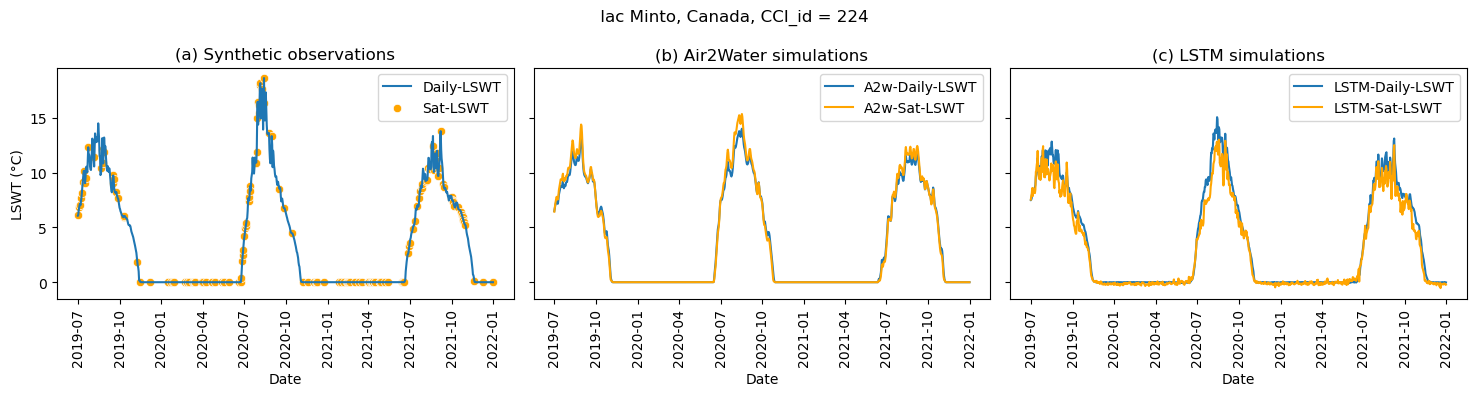

In [17]:
test_lake_id = "224"
lake_name = cci_lakes_gdf.loc[int(test_lake_id), "NAME"] + ", " + cci_lakes_gdf.loc[int(test_lake_id), "COUNTRY"]
a2w_full_sim = pd.read_csv(f"{a2w_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
a2w_cloud_sim = pd.read_csv(f"{a2w_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_full_sim = pd.read_csv(f"{lstm_full_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
lstm_cloud_sim = pd.read_csv(f"{lstm_cloud_dir}/{test_lake_id}.csv", index_col=0, parse_dates=True)
obs_full = pd.read_csv(obs_full_path, index_col=0, parse_dates=True).loc[:, test_lake_id]
obs_cloud = pd.read_csv(obs_cloud_path, index_col=0, parse_dates=True).loc[:, test_lake_id]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=True)
date_range = pd.date_range("2019-07-01", "2021-12-31")
fig_labels = ["(a)", "(b)", "(c)"]

# Time series of observations
sns.lineplot(obs_full.loc[date_range], label="Daily-LSWT", ax=axes[0], color="tab:blue")
sns.scatterplot(obs_cloud.loc[date_range], label="Sat-LSWT", ax=axes[0], color="orange")
axes[0].set_title(f"{fig_labels[0]} Synthetic observations")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("LSWT (°C)")
axes[0].legend()
axes[0].tick_params(axis='x', labelrotation=90, )
# Time series of Air2Water simulations
sns.lineplot(a2w_full_sim.mean(axis=1).loc[date_range], label="A2w-Daily-LSWT", ax=axes[1], color="tab:blue")
sns.lineplot(a2w_cloud_sim.mean(axis=1).loc[date_range], label="A2w-Sat-LSWT", ax=axes[1], color="orange")
axes[1].set_title(f"{fig_labels[1]} Air2Water simulations")
axes[1].set_xlabel("Date")
axes[1].legend()
axes[1].tick_params(axis='x', labelrotation=90, )
# Time series of LSTM simulations
sns.lineplot(lstm_full_sim.mean(axis=1).loc[date_range], label="LSTM-Daily-LSWT", ax=axes[2], color="tab:blue")
sns.lineplot(lstm_cloud_sim.mean(axis=1).loc[date_range], label="LSTM-Sat-LSWT", ax=axes[2], color="orange")
axes[2].set_title(f"{fig_labels[2]} LSTM simulations")
axes[2].set_xlabel("Date")
axes[2].legend()
axes[2].tick_params(axis='x', labelrotation=90, )
fig.suptitle(f"{lake_name}, CCI_id = {test_lake_id}")
plt.tight_layout()

In [10]:
fig.savefig("../figs/case5_a2w_over_prediction.png", dpi = 300, bbox_inches='tight')

# Combine

In [ ]:
staticmet